# Functional Neural Network with Adaptive Bases

In this notewboook, we present a PyTorch implementation of the model proposed in "Deep Learning for Functional Data Analysis with Adaptive Basis Layers", ICML 2021.

Unlike many functional networks, AdaFNNs take the raw functional data as input and learn to apply parsimonious dimension reduction that focuses only on information relevant to the target rather than irrelevant variation in the input. This operation is done through a novel _Basis Layer_ that consists of _basis nodes_ implemented as micro networks. In addition, the inference and training can be done in an end-to-end manner without preprocessing the data.

# Implementing AdaFNNs

First, we provide the code for two building blocks, a layer normalization module and feedforward network module (with skipping connection). We start by import the necessary packages.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

### Layer Normalization

The layer normalization was introduced in [Layer Normalization](https://arxiv.org/abs/1607.06450). It is a transposition of Batch Normalization. 

In [3]:
class LayerNorm(nn.Module):

    def __init__(self, d, eps=1e-6):
        super().__init__()
        # d is the normalization dimension
        self.d = d
        self.eps = eps
        self.alpha = nn.Parameter(torch.randn(d))
        self.beta = nn.Parameter(torch.randn(d))

    def forward(self, x):
        # x is a torch.Tensor
        # avg is the mean value of a layer
        avg = x.mean(dim=-1, keepdim=True)
        # std is the standard deviation of a layer (eps is added to prevent dividing by zero)
        std = x.std(dim=-1, keepdim=True) + self.eps
        return (x - avg) / std * self.alpha + self.beta

Next, we implement a feedforward network module.

In [4]:
class FeedForward(nn.Module):

    def __init__(self, in_d=1, hidden=[4,4,4], dropout=0.1, activation=F.relu):
        # in_d      : input dimension, integer
        # hidden    : hidden layer dimension, array of integers
        # dropout   : dropout probability, a float between 0.0 and 1.0
        # activation: activation function at each layer
        super().__init__()
        self.sigma = activation
        dim = [in_d] + hidden + [1]
        self.layers = nn.ModuleList([nn.Linear(dim[i-1], dim[i]) for i in range(1, len(dim))])
        self.ln = nn.ModuleList([LayerNorm(k) for k in hidden])
        self.dp = nn.ModuleList([nn.Dropout(dropout) for _ in range(len(hidden))])

    def forward(self, t):
        for i in range(len(self.layers)-1):
            t = self.layers[i](t)
            # skipping connection
            t = t + self.ln[i](t)
            t = self.sigma(t)
            # apply dropout
            t = self.dp[i](t)
        # linear activation at the last layer
        return self.layers[-1](t)

### Metric operations

To build an AdaFNN, we need three new operations: (1) $\langle f_1, f_2 \rangle$ (2) $\| f \|_2$ and (3) $\| f \|_1$. The last two can be established on the first one through: 

$$ \| f\|_2 = \sqrt{ \langle f, f \rangle} $$
and 
$$ \| f\|_1 = \langle 1, |f| \rangle .$$

Since the input is densely observed (equal spacing is not required), the inner product can be approximated by any numerical integration scheme. Here, we will use the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule).

In [5]:
def _inner_product(f1, f2, h):
    """    
    f1 - (B, J) : B functions, observed at J time points,
    f2 - (B, J) : same as f1
    h  - (J-1,1): weights used in the trapezoidal rule
    pay attention to dimension
    <f1, f2> = sum (h/2) (f1(t{j}) + f2(t{j+1}))
    """
    prod = f1 * f2 # (B, J = len(h) + 1)
    return torch.matmul((prod[:, :-1] + prod[:, 1:]), h.unsqueeze(dim=-1))/2

Then $L_1$ and $L_2$ can be easily implememnted as:

In [6]:
def _l1(f, h):
    # f dimension : ( B bases, J )
    B, J = f.size()
    return _inner_product(torch.abs(f), torch.ones((B, J)), h)

In [7]:
def _l2(f, h):
    # f dimension : ( B bases, J )
    # output dimension - ( B bases, 1 )
    return torch.sqrt(_inner_product(f, f, h)) 

### AdaFNN

To prevent the original scale of basis nodes from dominating regularizers, they are normalized.

With these in hand, we are ready to present the AdaFNN implmentation. 

In [8]:
class AdaFNN(nn.Module):

    def __init__(self, n_base=4, base_hidden=[64, 64, 64], grid=(0, 1),
                 sub_hidden=[128, 128, 128], dropout=0.1, lambda1=0.0, lambda2=0.0,
                 device=None):
        """
        n_base      : number of basis nodes, integer
        base_hidden : hidden layers used in each basis node, array of integers
        grid        : observation time grid, array of sorted floats including 0.0 and 1.0
        sub_hidden  : hidden layers in the subsequent network, array of integers
        dropout     : dropout probability
        lambda1     : penalty of L1 regularization, a positive real number
        lambda2     : penalty of L2 regularization, a positive real number
        device      : device for the training
        """
        super().__init__()
        self.n_base = n_base
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.device = device
        # grid should include both end points
        grid = np.array(grid)
        # send the time grid tensor to device
        self.t = torch.tensor(grid).to(device).float()
        self.h = torch.tensor(grid[1:] - grid[:-1]).to(device).float()
        # instantiate each basis node in the basis layer
        self.BL = nn.ModuleList([FeedForward(1, hidden=base_hidden, dropout=dropout, activation=F.selu)
                                 for _ in range(n_base)])
        # instantiate the subsequent network
        self.FF = FeedForward(n_base, sub_hidden, dropout)

    def forward(self, x):
        B, J = x.size()
        assert J == self.h.size()[0] + 1
        T = self.t.unsqueeze(dim=-1)
        # evaluate the current basis nodes at time grid
        self.bases = [basis(T).transpose(-1, -2) for basis in self.BL]
        """
        compute each basis node's L2 norm
        normalize basis nodes
        """
        l2_norm = _l2(torch.cat(self.bases, dim=0), self.h).detach()
        self.normalized_bases = [self.bases[i] / (l2_norm[i, 0] + 1e-6) for i in range(self.n_base)]
        # compute each score <basis_i, f> 
        score = torch.cat([_inner_product(b.repeat((B, 1)), x, self.h) # (B, 1)
                           for b in self.bases], dim=-1) # score dim = (B, n_base)
        # take the tensor of scores into the subsequent network
        out = self.FF(score)
        return out

    def R1(self, l1_k):
        """
        L1 regularization
        l1_k : number of basis nodes to regularize, integer        
        """
        if self.lambda1 == 0: return torch.zeros(1).to(self.device)
        # sample l1_k basis nodes to regularize
        selected = np.random.choice(self.n_base, min(l1_k, self.n_base), replace=False)
        selected_bases = torch.cat([self.normalized_bases[i] for i in selected], dim=0) # (k, J)
        return self.lambda1 * torch.mean(_l1(selected_bases, self.h))

    def R2(self, l2_pairs):
        """
        L2 regularization
        l2_pairs : number of pairs to regularize, integer  
        """
        if self.lambda2 == 0 or self.n_base == 1: return torch.zeros(1).to(self.device)
        k = min(l2_pairs, self.n_base * (self.n_base - 1) // 2)
        f1, f2 = [None] * k, [None] * k
        for i in range(k):
            a, b = np.random.choice(self.n_base, 2, replace=False)
            f1[i], f2[i] = self.normalized_bases[a], self.normalized_bases[b]
        return self.lambda2 * torch.mean(torch.abs(_inner_product(torch.cat(f1, dim=0),
                                                                  torch.cat(f2, dim=0),
                                                                  self.h)))

#  Data

### Data Generator

Data is generated based on the following model:

$$ X(t) \ = \ \sum_{k=1}^{50} c_k \phi_k (t), \quad t \in [0,1] ,$$ 
where terms on the right hand side are defined as:

1. $\phi_1 (t) = 1$ and $ \phi_k (t) = \sqrt{2} \cos ( (k-1) \pi t)$ for $k = 2, \dots, 50$.
2. $c_k = z_k r_k$, and $r_k$ are i.i.d. uniform random variables on $[-\sqrt{3}, \sqrt{3}]$.

Case 1: $z_1 = 20$, $z_2 = z_3 = 5$, and $z_k = 1$ for $k \geq 4$. $y = \big( \langle \phi_3, X \rangle \big)^2$.

Case 2 and 3: $z_1 = z_3 = 5$, $z_5 = z_{10} = 3$, and $z_k = 1$ for other $k$. $y = \big( \langle \phi_5, X \rangle \big)^2$.

Case 4: $X$ has the same configurations as Case 2. But $y=\langle \beta_2, X \rangle + \big( \langle \beta_1, X \rangle \big)^2$ with

$$ \beta_1 (t) = (4 - 16t) \cdot 1 \big\{ 0 \leq t \leq 1/4 \big\} $$
and
$$ \beta_2 (t) = \big( 4 - 16|t-1/2| \big) \cdot 1 \big\{ |t-1/2| \leq 1/4 \big\} .$$

For each time point $t$, the observed $X(t)$ may be contaminated by measurement error, i.e.

$$ \tilde{X} (t) = X (t) + \eta_t, \quad \eta_t \stackrel{i.i.d.}{\sim} N (0, \sigma^2_1) .$$

The response $y$ may also have noise, i.e. $\tilde{y} = y + \epsilon$ where $\epsilon \stackrel{i.i.d.}{\sim} N (0, \sigma^2_2)$.


First, we import necessary dependencies.

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path

Next, we list configurations for each cases and implememnt functions for generating $X$ and $y$.

In [10]:
z1 = [20, 5, 5] + [1] * 47
z2 = [1] * 50
z2[0] = z2[2] = 5
z2[4] = z2[9] = 3
Z = [z1, z2, z2, [1] * 50]


def _phi(k):
    if k == 1: return lambda t: np.ones((len(t),))
    return lambda t : np.sqrt(2) * np.cos((k-1) * np.pi * t)


def _b1(t):
    return (4 - 16 * t) * (0 <= t) * (t <= 1/4)


def _b2(t):
    return (4 - 16 * np.abs(1/2 - t)) * (1/4 <= t) * (t <= 3/4)

The DataGenerator class generates data and save it to csv files.

In [11]:
class DataGenerator:

    def __init__(self, grid, case=1, me=1, err=1):
        """
        grid : array of time points, floats
        case : case number, integer
        me   : variance of measurement error added to X, non-negative real value
        err  : variance of noise added to Y, non-negative real value
        """
        self.t = np.array(grid)
        # measurement error
        self.me = me
        self.err = err
        # case - 1
        self.case = case
        self.z = np.array(Z[case-1])

    def generate(self, n=1000):
        """
        n : number of subjects to generate, integer
        """
        # X = sum c_k phi_k
        # c_k = z_k r_k, r_k iid unif[-sqrt(3), sqrt(3)]
        # generate r
        r = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=(n, 50))
        c = r * self.z # (n, 50) elementwise multiplication
        phi = np.array([_phi(k)(self.t) for k in range(1, 51)]) # (50, len(self.t))
        X = np.matmul(c, phi) # (n, len(self.t))
        Y = np.zeros((n, 1))
        if self.case == 1:
            Y = (c[:, 2]) ** 2
        elif self.case == 4:
            beta1 = _b1(self.t)
            beta2 = _b2(self.t)
            h = np.array(self.t[1:] - self.t[:-1]).T
            for i in range(n):
                Y[i, 0] = self._inner_product(beta2, X[i, :], h) + self._inner_product(beta1, X[i, :], h) ** 2

        else: # self.case = 2 or 3
            Y = (c[:, 4]) ** 2        
        self.X = X + np.random.normal(0, self.me, size=(n, len(self.t)))
        self.Y = Y.reshape((n, 1)) + np.random.normal(0, self.err, size=(n, 1))
        
    def _inner_product(self, f1, f2, h):
        prod = f1 * f2
        if len(prod.shape) < 2:
            prod = prod.reshape((1, -1))
        res = np.matmul(prod[:, :-1] + prod[:, 1:], h) / 2
        return res

    def save(self, folder):
        """
        folder : folder where observations are saved
        """
        Path(folder).mkdir(parents=True, exist_ok=True)
        X_df = pd.DataFrame(self.X)
        Y_df = pd.DataFrame(self.Y)
        T_df = pd.DataFrame(self.t.reshape((1, -1)))
        X_df.to_csv(folder + "X.csv", index=False, header=None)
        Y_df.to_csv(folder + "Y.csv", index=False, header=None)
        T_df.to_csv(folder + "T.csv", index=False, header=None)

The time grid doesn't have to be equally spaced. The model works as long as the time gap is small enough for numerical integration to work well.

In [12]:
def random_grid(d=0.02):
    """
    d : maximum time gap between two consecutive time points, float
    """
    grid = [0.0]
    while 1.0 - grid[-1] > d:
        grid.append(grid[-1] + np.random.uniform(0, d, 1).item())
    return grid + [1.0]

### Data Loader

This module reads the dataset from csv files and split it according to a pre-specific train/valid/test ratio. The dataset is standardized.

In [13]:
from sklearn.preprocessing import StandardScaler

class DataLoader:

    def __init__(self, batch_size, X, Y, T, split=(8, 1, 1), random_seed=10294):        
        """
        batch_size : batch size, integer
        X - (n, J) : pandas.DataFrame for observed functional data, n - subject number, J - number of time points
        Y - (n, 1) : pandas.DataFrame for response
        split      : train/valid/test split
        random_seed: random seed for training data re-shuffle
        """        
        self.n, J = X.shape
        self.t = T.iloc[0, :].to_numpy()
        X, Y = X.values, Y.values

        # train/valid/test split
        self.batch_size = batch_size
        train_n = self.n // sum(split) * split[0]
        valid_n = self.n // sum(split) * split[1]
        test_n = self.n - train_n - valid_n
        self.train_B = train_n // batch_size
        self.valid_B = valid_n // batch_size
        self.test_B = test_n // batch_size

        # random shuffle
        np.random.seed(random_seed)
        _order = list(range(self.n))
        np.random.shuffle(_order)
        X = X[_order, :]
        Y = Y[_order, :]

        # standardize dataset based on the training dataset
        self.X_standardizer = StandardScaler()
        self.Y_standardizer = StandardScaler()

        # train/valid/test split
        self.train_X = X[:(self.train_B * self.batch_size), :]
        self.train_Y = Y[:(self.train_B * self.batch_size), :]
        self.X_standardizer.fit(self.train_X)
        self.Y_standardizer.fit(self.train_Y)
        self.train_X = self.X_standardizer.transform(self.train_X)
        self.train_Y = self.Y_standardizer.transform(self.train_Y)

        self.valid_X = X[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        self.valid_Y = Y[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        self.valid_X = self.X_standardizer.transform(self.valid_X)
        self.valid_Y = self.Y_standardizer.transform(self.valid_Y)

        self.test_X = X[((self.train_B + self.valid_B) * self.batch_size):, :]
        self.test_Y = Y[((self.train_B + self.valid_B) * self.batch_size):, :]
        self.test_X = self.X_standardizer.transform(self.test_X)
        self.test_Y = self.Y_standardizer.transform(self.test_Y)

    def shuffle(self):
        # re-shuffle the training dataset
        train_size = self.train_X.shape[0]
        new_order = list(range(train_size))
        np.random.shuffle(new_order)
        self.train_X = self.train_X[new_order, :]
        self.train_Y = self.train_Y[new_order, :]

    def _batch_generator(self, X, Y, N):

        def generator_func():
            for i in range(1, N):
                x = X[((i - 1) * self.batch_size):((i) * self.batch_size), :]
                y = Y[((i - 1) * self.batch_size):((i) * self.batch_size), :]

                yield torch.Tensor(x), torch.Tensor(y)

        return generator_func()

    def get_train_batch(self):
        return self._batch_generator(self.train_X, self.train_Y, self.train_B)

    def get_valid_batch(self):
        return self._batch_generator(self.valid_X, self.valid_Y, self.valid_B)

    def get_test_batch(self):
        return self._batch_generator(self.test_X, self.test_Y, self.test_B)

# Training the model

First, we load necessary packages.

In [14]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.optim import Adam

A dataset will be generated if it is not present. 

Here, we set the measurement error variance to be 1 and noise variance to be 0.2.

**Note**: in this example, we use a flexible time point gap (**not** equal spacing). 

In [15]:
if not Path("data").is_dir():
    d = 0.02
    # tp = np.arange(0, 1 + d, d)
    tp = random_grid(d)
    DatGen = DataGenerator(tp, case=3, me=1.0, err=0.2)
    DatGen.generate(4000)
    DatGen.save("data/")

The dataset is loaded and split for training/validation/test.

In [16]:
batch_size = 128
split = (64, 16, 20)

In [17]:
X = pd.read_csv("data/X.csv", header=None)
Y = pd.read_csv("data/Y.csv", header=None)
T = pd.read_csv("data/T.csv", header=None)
grid = T.iloc[0, :].to_list()
dataLoader = DataLoader(batch_size,  X, Y, T, split)

Prepare the model and other training configurations:

In [18]:
# set up CPU/GPU
device = torch.device("cpu") 
# model configuration
"""
You can use a different model by modifing base_hidden, sub_hidden, n_base.
"""
base_hidden = [256, 256, 256, 256]
sub_hidden = [64, 64]
n_base = 2
lambda1, l1_k = 0.0, 2
lambda2, l2_pairs = 0.0, 3
dropout = 0.1
save_model_every = 100
model = AdaFNN(n_base=n_base,
               base_hidden=base_hidden,
               grid=grid,
               sub_hidden=sub_hidden,
               dropout=dropout,
               lambda1=lambda1,
               lambda2=lambda2,
               device=device)
# send model to CPU/GPU
_ = model.to(device)

In [19]:
# training configuration
epoch = 500
pred_loss_train_history = []
total_loss_train_history = []
loss_valid_history = []
# instantiate an optimizer
optimizer = Adam(model.parameters(), lr=3e-4)
# use MSE loss
compute_loss = torch.nn.MSELoss()
min_valid_loss = sys.maxsize

Create a folder to save checkpoints.

In [20]:
folder = "train/"
Path(folder).mkdir(parents=True, exist_ok=True)

Save and load models:

In [21]:
def save_model(folder, k, n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer):
    checkpoint = {'n_base': n_base,
                  'base_hidden': base_hidden,
                  'grid': grid,
                  'sub_hidden': sub_hidden,
                  'dropout': dropout,
                  'lambda1' : lambda1,
                  'lambda2' : lambda2,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, folder + str(k) + '_' + 'checkpoint.pth')


def load_model(file_path, device):
    checkpoint = torch.load(file_path)
    model = AdaFNN(n_base=checkpoint['n_base'],
                   base_hidden=checkpoint['base_hidden'],
                   grid=checkpoint['grid'],
                   sub_hidden=checkpoint['sub_hidden'],
                   dropout=checkpoint['dropout'],
                   lambda1=checkpoint['lambda1'],
                   lambda2=checkpoint['lambda2'],
                   device=device)
    model.load_state_dict(checkpoint['state_dict'])
    _ = model.to(device)
    return model, checkpoint['grid']

Training procedure:

In [22]:
for k in range(epoch):

    if k and k % save_model_every == 0:
        save_model(folder, k, n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer)

    pred_loss_train = []
    total_loss_train = []
    loss_valid = []
    dataLoader.shuffle()
    # set model training state
    model.train()

    for i, (x, y) in enumerate(dataLoader.get_train_batch()):
        x, y = x.to(device), y.to(device)
        out = model.forward(x)
        loss_pred = compute_loss(out, y)
        loss = loss_pred + model.R1(l1_k) + model.R2(l2_pairs)
        # record training loss history
        total_loss_train.append(loss.item())
        pred_loss_train.append(loss_pred.item())

        # update parameters using backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss_train_history.append(np.mean(total_loss_train))
    pred_loss_train_history.append(np.mean(pred_loss_train))

    # model evaluation mode

    with torch.no_grad():
        model.eval()
        for x, y in dataLoader.get_valid_batch():
            x, y = x.to(device), y.to(device)
            valid_y = model.forward(x)
            valid_loss = compute_loss(valid_y, y)
            # print("valid - check out: ", check_tensor([valid_loss]))
            loss_valid.append(valid_loss.item())

    if np.mean(loss_valid) < min_valid_loss:
        save_model(folder, "best", n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer)
        min_valid_loss = np.mean(loss_valid)

    loss_valid_history.append(np.mean(loss_valid))
    
    if (k+1) % 50 == 0:
        print("epoch:", k+1, "\n",
              "prediction training loss = ", pred_loss_train_history[-1],
              "validation loss = ", loss_valid_history[-1])

epoch: 50 
 prediction training loss =  1.0092152325730575 validation loss =  0.9117863327264786
epoch: 100 
 prediction training loss =  1.0198108647999011 validation loss =  0.9127183258533478
epoch: 150 
 prediction training loss =  0.49460057835829885 validation loss =  0.4149135798215866
epoch: 200 
 prediction training loss =  0.10786365815683414 validation loss =  0.04820907302200794
epoch: 250 
 prediction training loss =  0.08378865903145388 validation loss =  0.06254738755524158
epoch: 300 
 prediction training loss =  0.07181917248587859 validation loss =  0.030116869136691093
epoch: 350 
 prediction training loss =  0.07683030104166583 validation loss =  0.021957298275083303
epoch: 400 
 prediction training loss =  0.06773263725795244 validation loss =  0.030310802161693573
epoch: 450 
 prediction training loss =  0.06542162891281278 validation loss =  0.04157965909689665
epoch: 500 
 prediction training loss =  0.06499655093801648 validation loss =  0.03089121775701642


Please note that the validation error was computed after a training epoch was complete. So the validation error is generally smaller than the training error. 

Make a loss plot after training finishes.

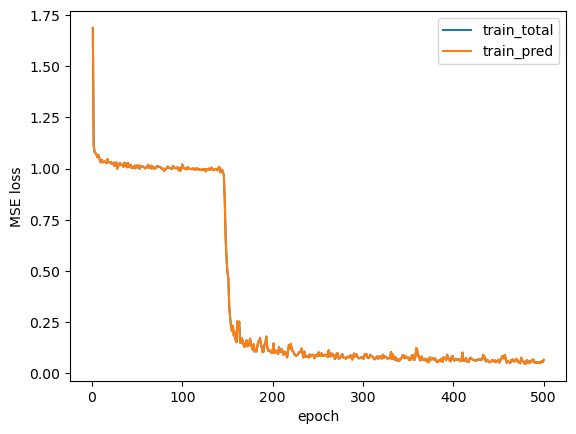

In [23]:
plt.plot(list(range(1, epoch+1)), total_loss_train_history, label='train_total')
plt.plot(list(range(1, epoch+1)), pred_loss_train_history, label='train_pred')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
# plt.savefig('loss_plot.png')
# plt.close()

After training, to make predictions, we can load the best model and run it on the (test) dataset.

In [24]:
def make_prediction(dataLoader, device=torch.device("cpu"), folder="train/"):
    ck = folder + "best_checkpoint.pth"
    # load the best model
    model, t = load_model(ck, device)
    T = torch.tensor(t).to(device)
    t = np.array(t)
    
    loss_test  = []
    y_pred = []
    
    with torch.no_grad():
        model.eval()
        """
        Get the performance of the best train model on test dataset
        """
        for x, y in dataLoader.get_test_batch():
            x, y = x.to(device), y.to(device)
            test_y = model.forward(x)
            y_pred.extend(test_y.detach().cpu().numpy().tolist())
            test_loss = compute_loss(test_y, y)
            loss_test.append(test_loss.item())        
        
    """
    Compute the MSE of the test dataset
    """
    print("test accuracy MSE :", np.mean(loss_test))
    
    """
    return the predicted y values by re-scaling the model output
    """
    
    return dataLoader.Y_standardizer.inverse_transform(y_pred)


In [25]:
y_pred = make_prediction(dataLoader)

test accuracy MSE : 0.020395083352923393


We can plot the learned bases.

In [28]:
def plot_bases( device=torch.device("cpu"), folder="train/"):
    ck = folder + "best_checkpoint.pth"
    model, t = load_model(ck, device)
    T = torch.tensor(t).to(device)
    t = np.array(t)

    bases = []
    
    loss_test  = []
    
    with torch.no_grad():
        model.eval()
        
        for i, basis in enumerate(model.BL):
            T = T.unsqueeze(dim=-1)
            y = np.squeeze(basis(T).squeeze(dim=-1).detach().cpu().numpy())
            y_sq = y ** 2
            l2_norm = np.sqrt(np.sum((y_sq[:-1] + y_sq[1:]) * (t[1:] - t[:-1])) / 2)
            bases.append(y / l2_norm)

    B = len(bases)
    fig, axs = plt.subplots(1, B)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    for i in range(B):        
        axs[i].plot(t, bases[i], linewidth=3.5, label="basis"+str(i+1))
        axs[i].legend()
    
    return bases


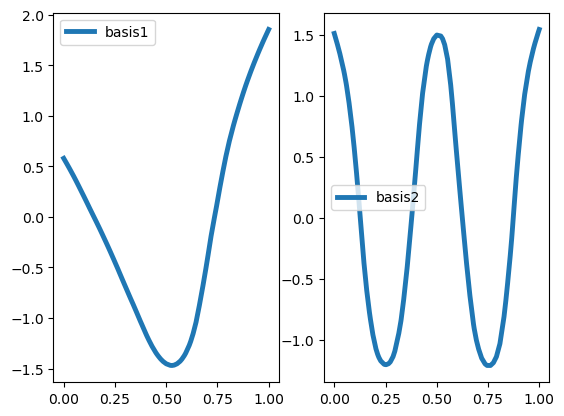

In [29]:
bases = plot_bases()

Even when both measurement error and noise were present, using roughly 60% of the dataset, the model successfully captured the important features of the true signal $\phi_5$. 

To better understand the learned bases, we can also plot a linear combination of them and see what it looks compared to the true one.

In [30]:
def plot(t, y, color, label):
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.plot(t, y, linewidth=3.5, color=color, label=label)
    plt.legend()

The coefficients of learned bases can vary in different experiments (see Theorem 1 and Remark 1 in the paper).

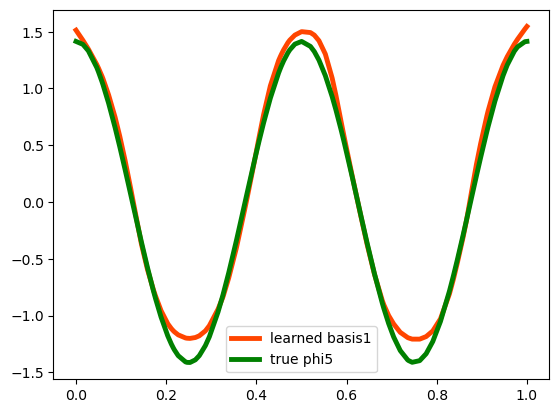

In [45]:
np_b = [np.array(b) for b in bases]
lin = np_b[1] #+ 0.4 * np_b[1] 
plot(grid, lin, "orangered", "learned basis1")
phi5 = _phi(5)
plot(grid, phi5(np.array(grid)), "green", "true phi5")

The true signal $\phi_5$ in Case 3 is drawn below. We can see that two bases learned the truth successfully.

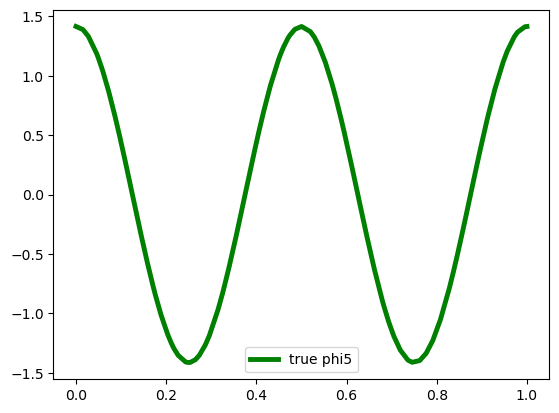

In [38]:
phi5 = _phi(5)
plot(grid, phi5(np.array(grid)), "green", "true phi5")